# 1) Data Preprocessing

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [4]:
df = pd.read_csv('/content/spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop garbage columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels (0 and 1)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1}) # create new column as 'b_labels'
y = df['b_labels'].values

In [11]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [12]:
# Convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [13]:
# Check word index mapping (to check the number of words in vocabulary)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are: %s' % V)

Total number of unique tokens are: 7292


In [14]:
# pad sequences (to get  N x T matrix)
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# N: number of samples and T: Number of time steps

Shape of data train tensor: (3733, 189)


In [15]:
# set the value of T to get sequence length
T = data_train.shape[1]

In [16]:
print(T)

189


In [17]:
# pad the test set
data_test = pad_sequences(sequences_test, maxlen=T)
# maxlen = T, to truncate longer sentences in test set
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


# 2) Building the Model

In [18]:

# Choose embedding dimensionality
D = 20  # this is a hyper parameter, we can choose any word vector size that we want

# Hidden state vectorsize (dimensionality)
M = 15

# Input layer
i = Input(shape=(T,))  # input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V + 1, D)(i) # This takes in sequences of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0

# LSTM layer
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation='sigmoid')(x)
# it is an binary classification problem, so we are using activation function ='sigmoid'

model = Model(i, x)


In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
r = model.fit(x=data_train, y=y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 18s 119ms/step - loss: 0.4528 - accuracy: 0.8626 - val_loss: 0.3796 - val_accuracy: 0.8728
Epoch 2/10
117/117 [==============================] - 7s 60ms/step - loss: 0.3940 - accuracy: 0.8626 - val_loss: 0.3698 - val_accuracy: 0.8728
Epoch 3/10
117/117 [==============================] - 5s 43ms/step - loss: 0.3742 - accuracy: 0.8626 - val_loss: 0.3404 - val_accuracy: 0.8728
Epoch 4/10
117/117 [==============================] - 5s 44ms/step - loss: 0.2770 - accuracy: 0.8749 - val_loss: 0.1786 - val_accuracy: 0.9734
Epoch 5/10
117/117 [==============================] - 2s 19ms/step - loss: 0.1287 - accuracy: 0.9821 - val_loss: 0.1022 - val_accuracy: 0.9799
Epoch 6/10
117/117 [==============================] - 3s 24ms/step - loss: 0.0742 - accuracy: 0.9890 - val_loss: 0.0839 - val_accuracy: 0.9859
Epoch 7/10
117/117 [==============================] - 2s 18ms/step - loss: 0.0507 - accuracy: 0.9912 - val_loss: 0.0780 - val_accuracy: 0.98

In [23]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding (Embedding)       (None, 189, 20)           145860    
                                                                 
 lstm (LSTM)                 (None, 189, 15)           2160      
                                                                 
 global_max_pooling1d (Glob  (None, 15)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 148036 (578.27 KB)
Trainable params: 148036 (578.27 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

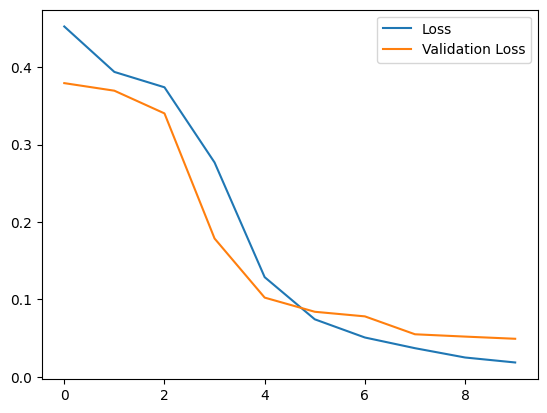

In [21]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

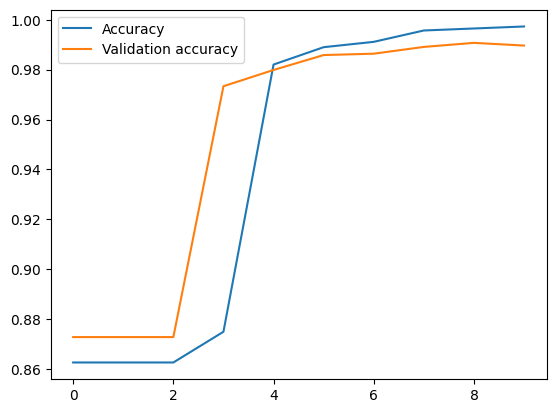

In [22]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()